# Лабораторная работа №4. Устранение выбросов и аномалий в данных





**Содержание**<a id='toc0_'></a>    
- 1. [Раздел 1. Импорт библиотек и загрузка данных](#toc1_)
- 2. [Раздел 2. Анализ выбросов и аномалий](#toc2_)
  - 2.1 [Анализ выбросов](#toc2_1_)
  - 2.2 [Анализ аномалий](#toc2_2_)
- 3. [Раздел 3. Сохранение результатов и вывод](#toc3_)

# 1. <a id='toc1_'></a>[Раздел 1. Импорт библиотек и загрузка данных](#toc1_)

### Цель работы  
Выполнить корректную очистку данных от выбросов и аномалий перед обучением моделей машинного обучения:  
- визуально проанализировать распределения числовых признаков с помощью диаграмм «ящик с усами»  
- обнаружить и удалить выбросы с использованием методов IQR и Robust Z-score (взять пересечение результатов)  
- обнаружить и удалить аномалии с использованием алгоритмов Isolation Forest, One-Class SVM и DBSCAN (взять пересечение результатов)  
- визуализировать найденные выбросы и аномалии, а также количество удалённых объектов  


**Формирование окружения для работы**

Первоначально необходимо подготовить окружение для работы с данными и их моделирования. Чтобы не возникало конфликтов виртуальной среды Python, зафиксируем используемые в ходе исследования версии основных библиотек и фреймворков, которые будут использоваться далее. А также пропишем последовательность команд для формирования среды.

Первоначально установим необходимые библиотеки при помощи пакетного менеджера `pip` в виртуальное окружение.

- Версия Python: 3.12.3

Сами версии можно получить с помощью команды:
`pip list --format=freeze`


In [1]:
#!pip install pyod DBSCAN

In [2]:
#!pip install --upgrade --force-reinstall -r requirements.txt

Как можно увидеть ниже в версии pyod 2.0.6 нет DBSCAN, но есть в sklearn.cluster.

| Библиотека / модуль               | Назначение                                                                 |
|-----------------------------------|-----------------------------------------------------------------------------|
| pandas                            | Работа с данными                                                            |
| numpy                             | Числовые вычисления                                                         |
| matplotlib.pyplot                 | Базовая визуализация                                                        |
| seaborn                           | Статистические графики                                                      |
| plotly.express                    | Интерактивные графики                                                       |
| warnings                          | Подавление предупреждений                                                   |
| sklearn.preprocessing.RobustScaler | Масштабирование устойчивым методом                                          |
| sklearn.ensemble.IsolationForest  | Обнаружение аномалий (Isolation Forest)                                     |
| sklearn.svm.OneClassSVM           | Обнаружение аномалий (One-class SVM)                                        |
| sklearn.decomposition.PCA         | Понижение размерности для визуализации                                      |
| sklearn.cluster.DBSCAN            | Обнаружение аномалий (DBSCAN)                                               |
| scipy.stats                       | Robust Z-score и статистика                                                 |

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from scipy import stats

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [4]:
import pyod.models
import pkgutil
print("pyod version:", pyod.__version__)
print([m.name for m in pkgutil.iter_modules(pyod.models.__path__)])

pyod version: 2.0.6
['abod', 'ae1svm', 'alad', 'anogan', 'auto_encoder', 'base', 'base_dl', 'cblof', 'cd', 'cof', 'combination', 'copod', 'deep_svdd', 'devnet', 'dif', 'ecod', 'feature_bagging', 'gaal_base', 'gmm', 'hbos', 'iforest', 'inne', 'kde', 'knn', 'kpca', 'lmdd', 'loci', 'loda', 'lof', 'lscp', 'lunar', 'mad', 'mcd', 'mo_gaal', 'ocsvm', 'pca', 'qmcd', 'rgraph', 'rod', 'sampling', 'sklearn_base', 'so_gaal', 'so_gaal_new', 'sod', 'sos', 'suod', 'thresholds', 'vae', 'xgbod']


Для воспроизводимости результатов исследования зафиксируем основание генератора случайных чисел.

In [5]:
SEED = 42
np.random.seed(SEED)

###  Загрузка данных из предыдущей работы

Берём датасет с MICE

In [6]:
train = pd.read_csv('train_mice.csv')
test  = pd.read_csv('test_mice.csv')
print(f"Размер до очистки: {train.shape}")

Размер до очистки: (9547, 17)


## 2. <a id='toc2_'></a>[Раздел 2. Анализ выбросов и аномалий](#toc2_)

## 2.1. <a id='toc2_1_'></a>[Анализ выбросов](#toc2_1_)

Для начала проанализируем графики для визуального определения наличия выбросов.

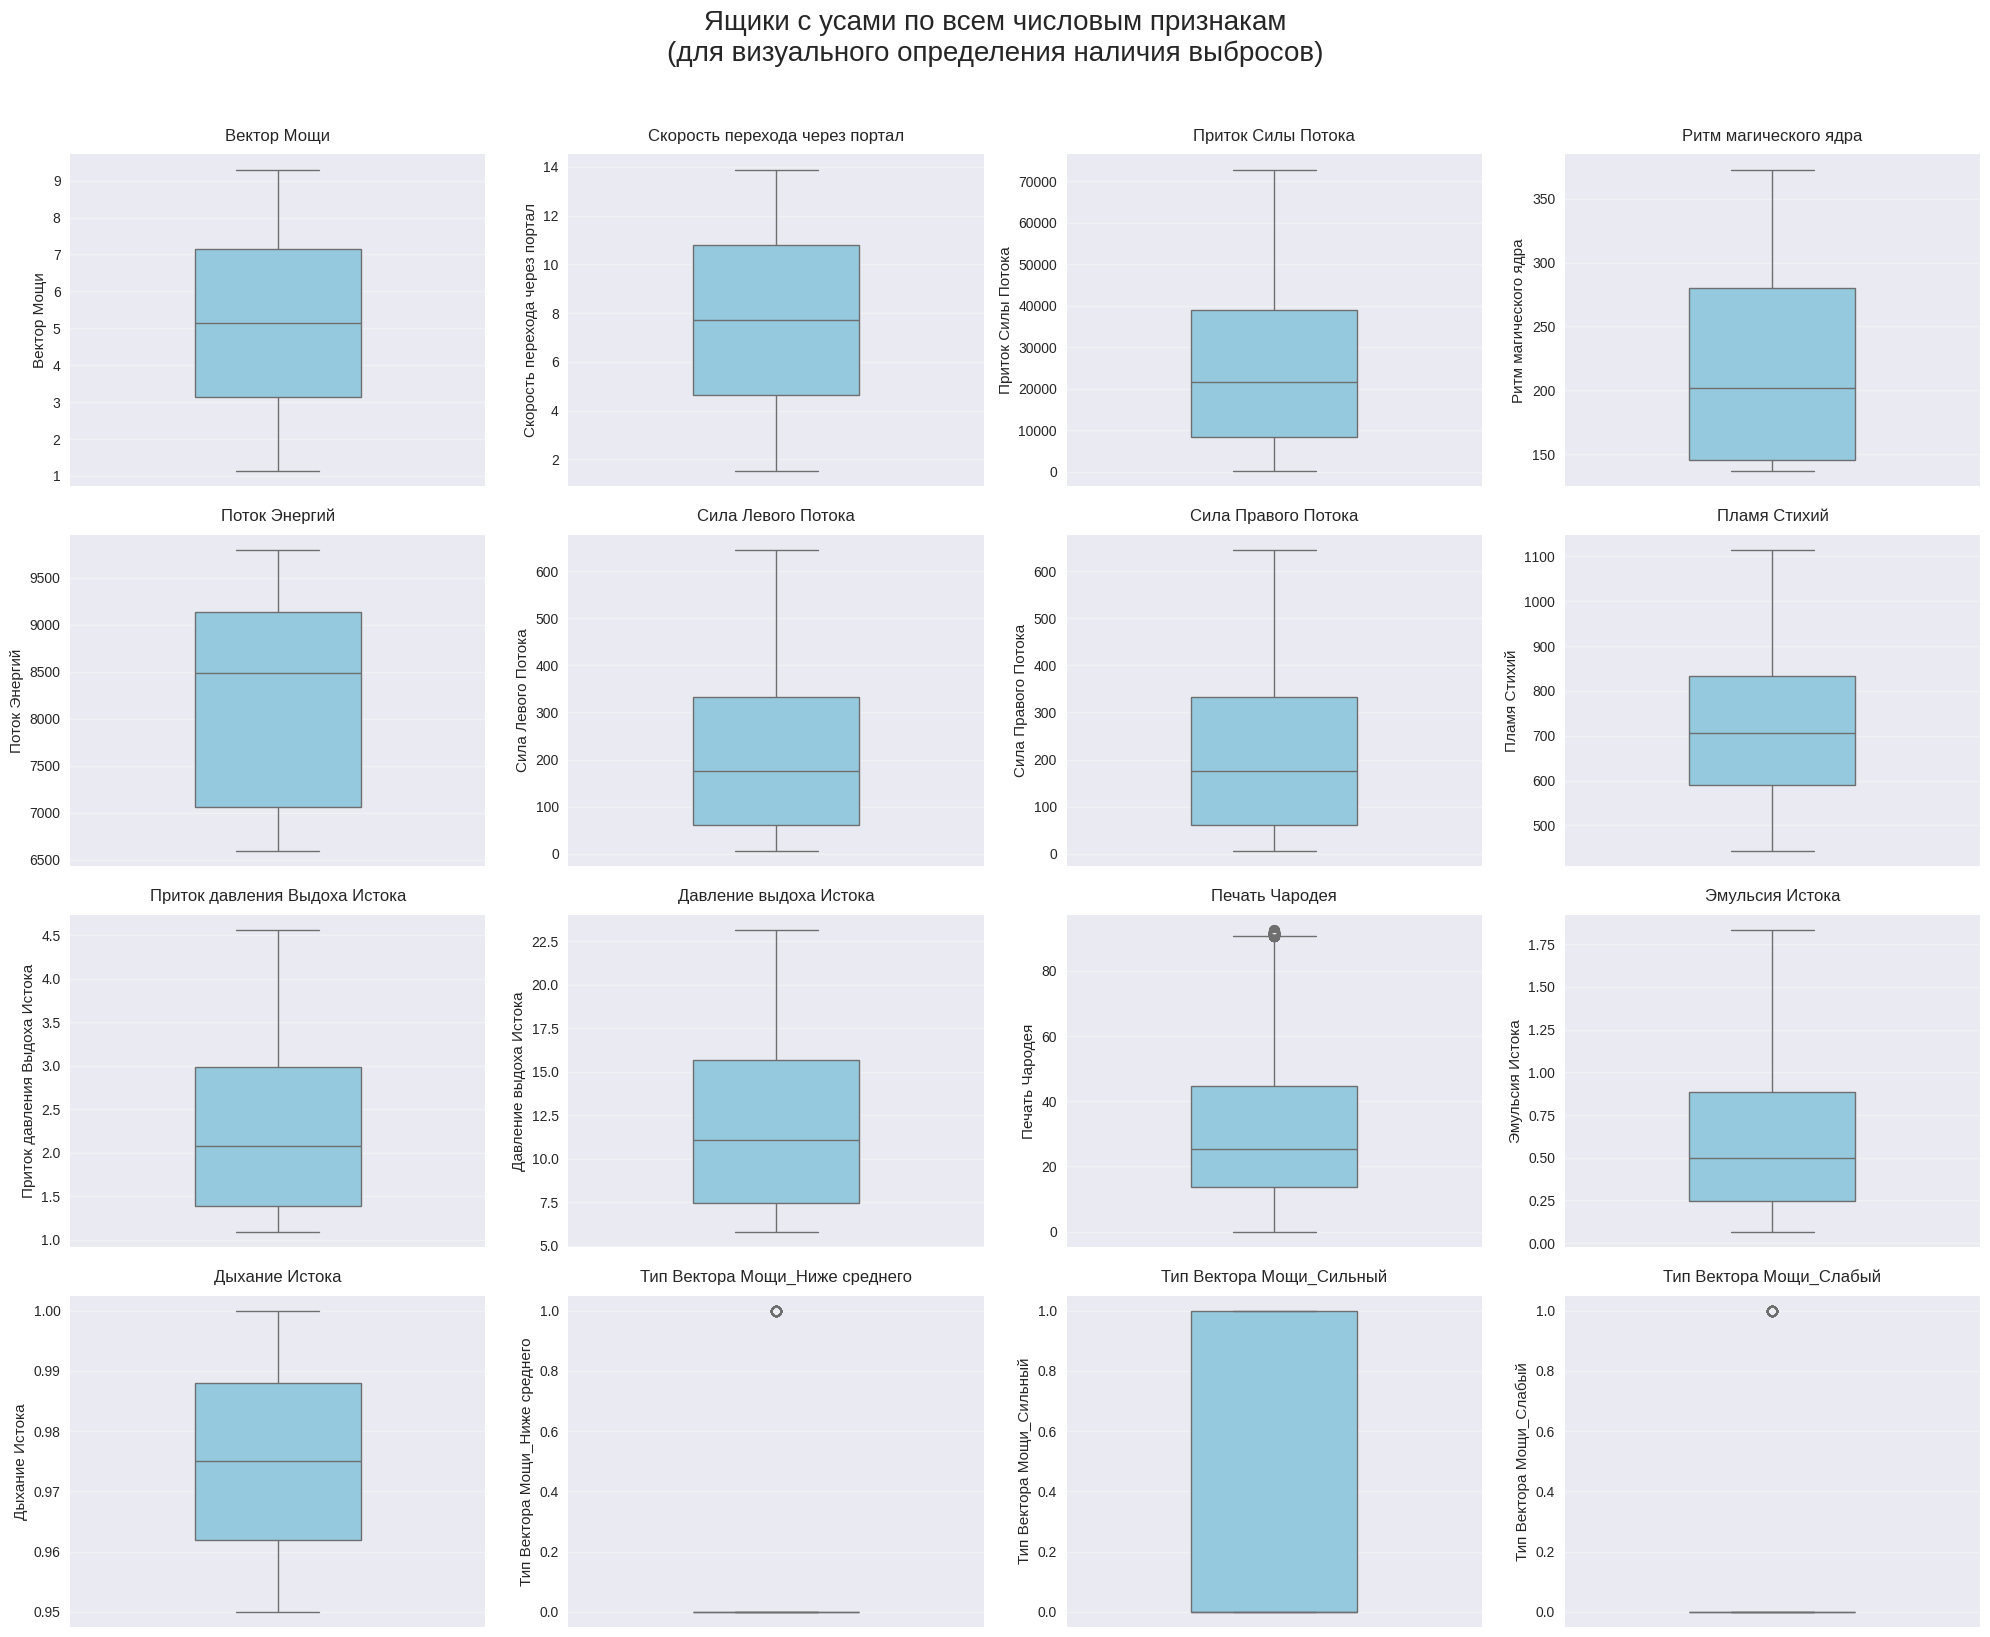

In [7]:
numeric_cols = train.select_dtypes(include=np.number).columns.drop('Гармония Бессмертия')

n_cols = len(numeric_cols)
n_rows = (n_cols + 3) // 4

plt.figure(figsize=(20, 4 * n_rows))
plt.suptitle('Ящики с усами по всем числовым признакам\n(для визуального определения наличия выбросов)',
             fontsize=20, y=1.02)

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, 4, i)
    sns.boxplot(y=train[col], orient='v', color='skyblue', width=0.4)
    plt.title(col, fontsize=12, pad=10)
    plt.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

- Явных точечных выбросов почти нет. Единственный заметный выброс — в признаке «Печать Чародея» (точки ≈ 90).

Поиск выбросов: IQR + Robust Z-score (пересечение)
- **IQR** — классический метод: всё за пределами `[Q1−1.5·IQR; Q3+1.5·IQR]` считается выбросом  
- **Robust Z-score** — модифицированный Z-score на основе медианы и MAD (Median Absolute Deviation)

In [8]:
col_with_outliers = 'Печать Чародея'

# IQR
Q1 = train[col_with_outliers].quantile(0.25)
Q3 = train[col_with_outliers].quantile(0.75)
IQR = Q3 - Q1
lower_iqr = Q1 - 1.5 * IQR
upper_iqr = Q3 + 1.5 * IQR
outliers_iqr = train[(train[col_with_outliers] < lower_iqr) | (train[col_with_outliers] > upper_iqr)].index

# Robust Z-score
median = train[col_with_outliers].median()
mad = np.median(np.abs(train[col_with_outliers] - median))
if mad > 0:
    modified_z = 0.6745 * (train[col_with_outliers] - median) / mad
    outliers_z = train[np.abs(modified_z) > 3.3496].index
else:
    outliers_z = set()

# Пересечение
common_outliers = set(outliers_iqr).intersection(set(outliers_z))

print(f"Выбросы найдены только в признаке '{col_with_outliers}'")
print(f"По IQR: {len(outliers_iqr)} строк")
print(f"По Robust Z-score (threshold=3.3496): {len(outliers_z)} строк")
print(f"Пересечение (финальные выбросы): {len(common_outliers)} строк")

Выбросы найдены только в признаке 'Печать Чародея'
По IQR: 186 строк
По Robust Z-score (threshold=3.3496): 186 строк
Пересечение (финальные выбросы): 186 строк


Удаление строк с выбросами

In [9]:
train_clean = train.drop(index=common_outliers).reset_index(drop=True)
print(f"После удаления выбросов: {train_clean.shape[0]} строк (удалено {len(common_outliers)})")

После удаления выбросов: 9361 строк (удалено 186)


## 2.2. <a id='toc2_2_'></a>[Анализ аномалий](#toc2_2_)

Поиск аномалий: Isolation Forest + One-class SVM + DBSCAN (sklearn)
- **Isolation Forest** — изолирует аномалии быстрее, чем нормальные объекты  
- **One-class SVM** — строит гиперсферу вокруг основной массы данных  
- **DBSCAN** — группирует объекты по плотности, помечая шум как аномалии (-1)

In [10]:
# Масштабируем
scaler = RobustScaler()
X_scaled = scaler.fit_transform(train_clean.drop('Гармония Бессмертия', axis=1))

# Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
iso_pred = iso.fit_predict(X_scaled)
iso_anomalies = np.where(iso_pred == -1)[0]

# One-class SVM
ocsvm = OneClassSVM(kernel='rbf', nu=0.05)
ocsvm_pred = ocsvm.fit_predict(X_scaled)
ocsvm_anomalies = np.where(ocsvm_pred == -1)[0]

# DBSCAN и подбор параметров (eps, min_samples)
eps_range = np.arange(0.5, 3.1, 0.5)
min_samples_range = range(5, 21, 5)

best_eps = 0.5
best_min_samples = 5
best_n_anomalies = np.inf

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        n_anomalies = np.sum(labels == -1)
        print(f"eps={eps}, min_samples={min_samples}: аномалий={n_anomalies}")
        if 0 < n_anomalies < best_n_anomalies:
            best_n_anomalies = n_anomalies
            best_eps = eps
            best_min_samples = min_samples

print(f"Лучшие параметры: eps={best_eps}, min_samples={best_min_samples} (аномалий={best_n_anomalies})")

# DBSCAN с лучшими параметрами
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan.fit(X_scaled)
dbscan_anomalies = np.where(dbscan.labels_ == -1)[0]

# Пересечение
common_anomalies = set(iso_anomalies) & set(ocsvm_anomalies) & set(dbscan_anomalies)
print(f"Найдено аномалий (пересечение 3 методов): {len(common_anomalies)}")

eps=0.5, min_samples=5: аномалий=0
eps=0.5, min_samples=10: аномалий=0
eps=0.5, min_samples=15: аномалий=0
eps=0.5, min_samples=20: аномалий=0
eps=1.0, min_samples=5: аномалий=0
eps=1.0, min_samples=10: аномалий=0
eps=1.0, min_samples=15: аномалий=0
eps=1.0, min_samples=20: аномалий=0
eps=1.5, min_samples=5: аномалий=0
eps=1.5, min_samples=10: аномалий=0
eps=1.5, min_samples=15: аномалий=0
eps=1.5, min_samples=20: аномалий=0
eps=2.0, min_samples=5: аномалий=0
eps=2.0, min_samples=10: аномалий=0
eps=2.0, min_samples=15: аномалий=0
eps=2.0, min_samples=20: аномалий=0
eps=2.5, min_samples=5: аномалий=0
eps=2.5, min_samples=10: аномалий=0
eps=2.5, min_samples=15: аномалий=0
eps=2.5, min_samples=20: аномалий=0
eps=3.0, min_samples=5: аномалий=0
eps=3.0, min_samples=10: аномалий=0
eps=3.0, min_samples=15: аномалий=0
eps=3.0, min_samples=20: аномалий=0
Лучшие параметры: eps=0.5, min_samples=5 (аномалий=inf)
Найдено аномалий (пересечение 3 методов): 0


Визуализация аномалий на двумерной плоскости (PCA)

In [11]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'type': 'Норма'
})
df_plot.loc[list(common_anomalies), 'type'] = 'Аномалия'

fig = px.scatter(df_plot, x='PC1', y='PC2', color='type',
                 title='Аномалии (пересечение 3 методов) на плоскости PCA',
                 color_discrete_map={'Норма': 'lightblue', 'Аномалия': 'red'})
fig.show()

- Три алгоритма (Isolation Forest + One-Class SVM + DBSCAN) **не нашли ни одной общей аномалии** (пересечение = 0).
- DBSCAN при всех протестированных параметрах (eps от 0.5 до 3.0, min_samples от 5 до 20) пометил все объекты как часть кластера или не нашёл аномалий.


## 3. <a id='toc3_'></a>[Раздел 3. Сохранение результатов и вывод](#toc3_)

### Сохранение результатов ЛР №4


In [14]:
train_final = train_clean.copy()
test_final = test.copy()

train_final.to_csv('train_clean_final.csv', index=False)
test_final.to_csv('test_clean_final.csv', index=False)

print("Готово! Очищенные датасеты сохранены:")
print("→ train_clean_final.csv (удалено 186 строк выбросов)")
print("→ test_clean_final.csv (аномалии не удалялись")

Готово! Очищенные датасеты сохранены:
→ train_clean_final.csv (удалено 186 строк выбросов)
→ test_clean_final.csv (аномалии не удалялись


### Итоговый вывод

1. **Выбросы (IQR + Robust Z-score, пересечение)**:  
   - Визуально по ящикам с усами выбросы обнаружены только в признаке **«Печать Чародея»**.  
   - IQR: 186 строк  
   - Robust Z-score (threshold ≈ 3.35): 186 строк  
   - Пересечение: **186 строк удалено**.

2. **Аномалии (Isolation Forest + One-Class SVM + DBSCAN, пересечение)**:  
   - Пересечение трёх алгоритмов: **0 строк**.  
   - DBSCAN при всех протестированных параметрах не нашёл аномалий — данные после удаления выбросов плотные и однородные.  
   - Дополнительное удаление по аномалиям не проводилось.

3. **Итог очистки**:  
   Исходно — 9547 строк → после удаления выбросов осталось **9361 строка** (удалено 186 строк, ~1.95 %).  

**Примечание:**  
Большая часть данных чистая. Удалены только объекты с экстремально высоким значением «Печать Чародея» — вероятнее всего, редкие режимы максимальной нагрузки.  

Чистые датасеты сохранены.